In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from pytorch_model_summary import summary

In [2]:
import torchvision
import torchvision.datasets as datasets

In [3]:
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.base(x)
        x = self.fc3(x)
        return x

#### Baseline on general architecture with one optimizer one whole train.

##### SGD

In [6]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [7]:
acc_val = []
loss_train = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 2.110
Accuracy of the network on the 10000 test images: 33 %
[1,  2000] loss: 1.760
Accuracy of the network on the 10000 test images: 41 %
[2,  1000] loss: 1.485
Accuracy of the network on the 10000 test images: 47 %
[2,  2000] loss: 1.394
Accuracy of the network on the 10000 test images: 52 %
[3,  1000] loss: 1.291
Accuracy of the network on the 10000 test images: 54 %
[3,  2000] loss: 1.223
Accuracy of the network on the 10000 test images: 54 %
[4,  1000] loss: 1.115
Accuracy of the network on the 10000 test images: 58 %
[4,  2000] loss: 1.100
Accuracy of the network on the 10000 test images: 60 %
[5,  1000] loss: 0.999
Accuracy of the network on the 10000 test images: 62 %
[5,  2000] loss: 0.986
Accuracy of the network on the 10000 test images: 63 %
[6,  1000] loss: 0.898
Accuracy of the network on the 10000 test images: 64 %
[6,  2000] loss: 0.893
Accuracy of the network on the 10000 test images: 65 %
[7,  1000] loss: 0.786
Accuracy of the network on the 10000 test

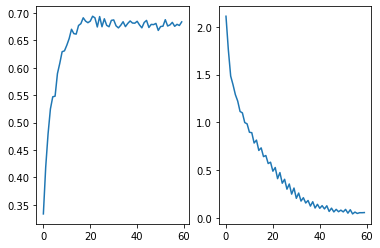

In [8]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

##### Adam

In [9]:
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [10]:
acc_val = []
loss_train = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)

print('Finished Training')

[1,  1000] loss: 0.945
Accuracy of the network on the 10000 test images: 59 %
[1,  2000] loss: 0.946
Accuracy of the network on the 10000 test images: 62 %
[2,  1000] loss: 0.777
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 0.852
Accuracy of the network on the 10000 test images: 66 %
[3,  1000] loss: 0.685
Accuracy of the network on the 10000 test images: 66 %
[3,  2000] loss: 0.751
Accuracy of the network on the 10000 test images: 67 %
[4,  1000] loss: 0.578
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.659
Accuracy of the network on the 10000 test images: 67 %
[5,  1000] loss: 0.498
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.571
Accuracy of the network on the 10000 test images: 67 %
[6,  1000] loss: 0.418
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.491
Accuracy of the network on the 10000 test images: 66 %
[7,  1000] loss: 0.367
Accuracy of the network on the 10000 test

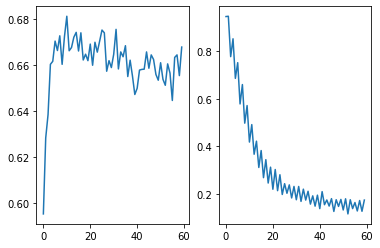

In [11]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

#### Combine SGD output and adam hidden

In [12]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.fc3.parameters(), lr=0.001, momentum=0.9)
optimizer_hidden = optim.Adam(cnn.base.parameters(), lr=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [13]:
acc_val = []
loss_train = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_hidden.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer_hidden.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.582
Accuracy of the network on the 10000 test images: 48 %
[1,  2000] loss: 1.301
Accuracy of the network on the 10000 test images: 57 %
[2,  1000] loss: 1.067
Accuracy of the network on the 10000 test images: 59 %
[2,  2000] loss: 1.037
Accuracy of the network on the 10000 test images: 63 %
[3,  1000] loss: 0.864
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.880
Accuracy of the network on the 10000 test images: 65 %
[4,  1000] loss: 0.722
Accuracy of the network on the 10000 test images: 64 %
[4,  2000] loss: 0.748
Accuracy of the network on the 10000 test images: 65 %
[5,  1000] loss: 0.600
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.654
Accuracy of the network on the 10000 test images: 67 %
[6,  1000] loss: 0.502
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.558
Accuracy of the network on the 10000 test images: 67 %
[7,  1000] loss: 0.428
Accuracy of the network on the 10000 test

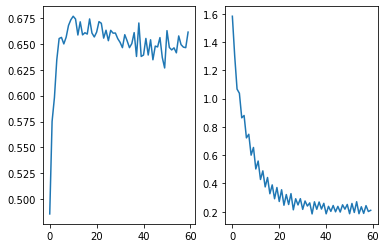

In [14]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

#### Combine adam output and SGD hidden

In [15]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.base.parameters(), lr=0.001)
optimizer_hidden = optim.SGD(cnn.fc3.parameters(), lr=0.001, momentum=0.9)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [16]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_hidden.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer_hidden.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.596
Accuracy of the network on the 10000 test images: 48 %
[1,  2000] loss: 1.300
Accuracy of the network on the 10000 test images: 57 %
[2,  1000] loss: 1.070
Accuracy of the network on the 10000 test images: 60 %
[2,  2000] loss: 1.040
Accuracy of the network on the 10000 test images: 64 %
[3,  1000] loss: 0.857
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.890
Accuracy of the network on the 10000 test images: 66 %
[4,  1000] loss: 0.725
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.763
Accuracy of the network on the 10000 test images: 67 %
[5,  1000] loss: 0.623
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.648
Accuracy of the network on the 10000 test images: 68 %
[6,  1000] loss: 0.520
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.573
Accuracy of the network on the 10000 test images: 66 %
[7,  1000] loss: 0.443
Accuracy of the network on the 10000 test

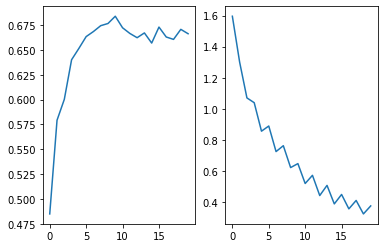

In [17]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)